In [193]:
import requests
from pprint import pprint

In [194]:
from bs4 import BeautifulSoup
import re

In [195]:
!pip install tqdm


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [196]:
from tqdm.auto import tqdm

In [197]:
import pandas as pd

In [211]:
import time
from datetime import datetime

In [212]:
import random

In [226]:
!pip install fake_useragent

  Obtaining dependency information for fake_useragent from https://files.pythonhosted.org/packages/33/c9/ff44922639b8827dbc86d463d870dabfc19d1567d8a6427dcb2289d83fd8/fake_useragent-1.4.0-py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [227]:
from fake_useragent import UserAgent

In [230]:
from collections import Counter

In [239]:
import matplotlib.pyplot as plt
%matplotlib inline
import re

session = requests.session()

In [201]:
def parse_newsblock(single_bl):
    
    # Создаем пустой словарь: keys будут названия колонок, values - текст из html
    post_dict = {}

    # Для каждой колонки подбираем значение из html
    a = single_bl.find('a')
    post_dict['href'] = a.attrs['href']
    post_dict['tag'] = (single_bl.find('div', {'class': 'rd-category'}).text).strip()
    post_dict['title'] = single_bl.find('h3', {'class': 'rd-title'}).text
    post_dict['preview_text'] = single_bl.find('div', {'class': 'rd-excerpt'}).text
    post_dict['date'] = single_bl.find('li', {'class': 'rd-date'}).text
    post_dict['views'] = single_bl.find('li', {'class': 'rd-view'}).text
    
    return post_dict

In [202]:
# Вся полезная информация для датасета доступна из блока новости, поэтому здесь достаем только текст статьи
# На вход идет словарь, полученный через parse_newsblock

def parse_post(post_dict):

    # Достаем ссылку на саму новость
    link = post_dict['href']

    # Качаем html самой новости и парсим
    request = session.get(link)
    page_1 = request.text
    new_soup = BeautifulSoup(page_1, 'html.parser')

    # Достаем текст
    post_dict['full_text'] = new_soup.find('section', {'class': 'rd-post-content'}).text     
    
    return post_dict

In [205]:
def process_page(page_number):
    
    main_url = f'https://tv-karelia.ru/category/lenta-novostey/page/{page_number}/'
    main_req = session.get(main_url)
    main_page = main_req.text
    more_soup = BeautifulSoup(main_page, 'html.parser')
    
    # Находим все куски html, которые отвечают за блоки новостей
    news = more_soup.find_all('li', {'class': 'rd-post-item'})

    # Будущий список словарей
    block_list = []
    
    # Проходимся по списку блоков и каждый пропускаем через обе функции
    for piece in news:
        try:
            res = parse_newsblock(piece)
            fin_res = parse_post(res)
        except Exception as e:
            print(e)

        # Конечный словарь кладем в список
        block_list.append(fin_res)

    return block_list

In [228]:
# Основная функция, на вход количество страниц 

def create_data(n_pages):
    
    block_list = []
    
    for i in tqdm(range(n_pages)):
        block_list.extend(process_page(i+1))
        time.sleep(random.uniform(0.5, 2))
    
    return block_list

In [229]:
# Создаем датафрейм

w = create_data(100)
df = pd.DataFrame(w)
df.to_csv("resul_df.csv", sep=',', index=False, encoding='utf-8')

  0%|          | 0/100 [00:00<?, ?it/s]

In [236]:
# Вывести топ 5 популярных тэгов

df = pd.read_csv('resul_df.csv', usecols=['tag'])
top_5 = df['tag'].value_counts().nlargest(5)
print(top_5)

Общество        344
Происшествия    327
Погода          130
Спорт            43
Медицина         41
Name: tag, dtype: int64


<Axes: ylabel='tag'>

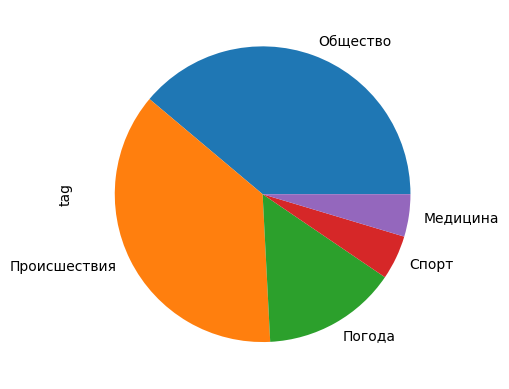

In [242]:
# Строим круговую диаграмму по тэгам 

df['tag'].value_counts().head(5).plot.pie()